We are using the famous Gompertzian model of tumor growth used for modeling rate of change of tumour with time in oncology using UDE.
\begin{align*}\frac{d T}{dt} = r * T * \ln(\frac{K}{T}) - C(t) *T ,\end{align*}

Where

T(t): Tumor size at time t \\
r: Tumor growth rate \\
K: Carrying capacity, maximum tumor size possible in the environment \\
c(t): Chemotheraphy induced killing rate \\

We will replace r and K with neural network in UDE to estimate it.

In [1]:
!pip install torchdiffeq

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp # Numerically solve to simulate real data
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint # Numericaly integrate UDe

%matplotlib inline

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `methos`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


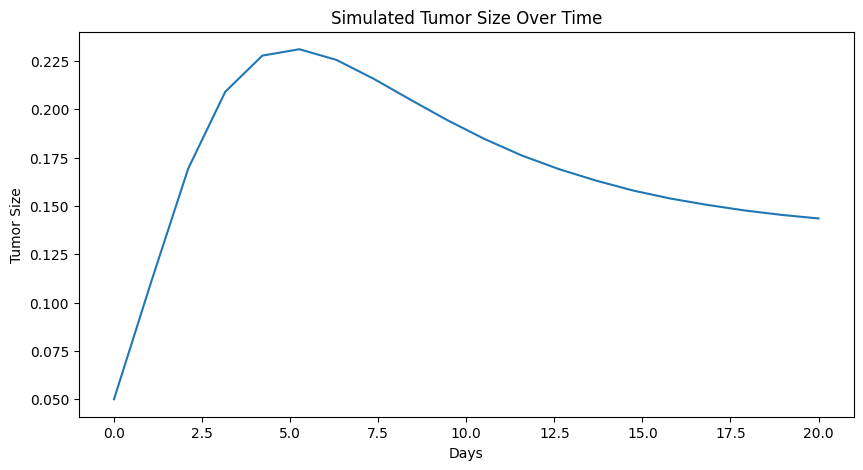

In [3]:
N_days = 20 # Simulation duration
N_days2 = N_days//4 # Training duration
t0 = 0.05 # Initial Tumour Size

# True Params for synthetic dataset generation
p0 = [0.5, 1.0, 1] # r, K, c
u0 = [t0]

t_span = [0.0, float(N_days)] # Time span
t = np.linspace(t_span[0], t_span[1], N_days) # Simulation dates

# Convert initial conditions to tensor
u0_tensor = torch.tensor(u0, dtype=torch.float32)
t_span_tensor = torch.tensor(t[:N_days2], dtype=torch.float32)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def simulated(t, u, p):
  T = max(u[0], 0) # Tumor size cannot be zero
  r, K, c = p
  return [r * T * np.log(K / T) - c * sigmoid(t/5) * T] # Here c(t) = c*sig(current day number / 5), means we increase schemo strength

sol = solve_ivp(simulated, t_span, u0, t_eval=t, args=(p0,), methos="RK45")
T_true = sol.y[0] # True tumor size for all days

plt.figure(figsize=(10, 5))
plt.plot(t, T_true)
plt.xlabel("Days")
plt.ylabel("Tumor Size")
plt.title("Simulated Tumor Size Over Time")
plt.show()

In [4]:
# Define the neural network
class rKNN(nn.Module):
  def __init__(self):
    super(rKNN, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(1, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )

  def forward(self, x):
    x = x.unsqueeze(0)  # Add a dimension
    return self.net(x)

model_r = rKNN()
model_K = rKNN()

In [5]:
# Define UDE Model
class tumor_model_UDE(nn.Module):
  def __init__(self, model_r, model_K):
    super(tumor_model_UDE, self).__init__()
    self.model_r = model_r
    self.model_K = model_K

  def forward(self, t, u):
    t = t.type(u[0].dtype).requires_grad_(True) # Ensure t is a tensor with gradient tracking
    T = max(u[0],0).view(1)
    r_pred = self.model_r(T)
    K_pred = self.model_K(T)

    # Apply clamp and activation
    r = torch.clamp(torch.log(1 + torch.exp(r_pred)), 1e-4, 1.0)
    K = torch.clamp(torch.log(1 + torch.exp(K_pred)), 0.01, 1.0)

    # Apply UDE dynamics
    return torch.stack([r * T * torch.log(K / T) - p0[2] * torch.sigmoid(t/5) * T]).requires_grad_(True)

In [6]:
# Define loss function
def loss_function(model_r, model_K):
  ude_model = tumor_model_UDE(model_r, model_K)
  try:
    # Numerically integrate
    sol = odeint(ude_model, u0_tensor, t_span_tensor, method='rk4')

    # Check for numerical stability
    if torch.any(torch.isnan(sol)):
      return torch.tensor(float('inf'), requires_grad=True)

    # Calculate the MSE
    pred_T = sol[:,0]
    true_T = torch.tensor(T_true[:N_days2], dtype=torch.float32)
    mse = torch.sum((pred_T - true_T)**2)

    return mse
  except Exception as e:
    print(f"Error: {e}")
    return torch.tensor(float('inf'), requires_grad=True)

In [7]:
# Train the model
def closure():
  optimizer.zero_grad()
  loss = loss_function(model_r, model_K)
  print(f"Loss: {loss.item()}")
  loss.backward()
  return loss

optimizer = optim.LBFGS(list(model_r.parameters()) + list(model_K.parameters()), lr=0.1, max_iter=20, line_search_fn="strong_wolfe")
print("Training the model")
optimizer.step(closure)
loss = loss_function(model_r, model_K)
print(f"Final Loss: {loss.item()}")

Training the model
Loss: 0.14897634088993073
Loss: 0.12898661196231842
Loss: 0.11387763917446136
Loss: 0.06122109293937683
Loss: 0.054112158715724945
Loss: 0.013181650079786777
Loss: 0.011755719780921936
Loss: 0.0034727193415164948
Loss: 0.0032135015353560448
Loss: 0.001883515971712768
Loss: 0.0018715615151450038
Loss: 0.0018147258087992668
Loss: 0.0018143586348742247
Loss: 0.0018119150772690773
Loss: 0.001810931833460927
Loss: 0.0018042136216536164
Loss: 0.0018035501707345247
Loss: 0.0018005650490522385
Loss: 0.0017711777472868562
Loss: 0.0017603333108127117
Loss: 0.0016691199271008372
Loss: 0.0013203731505200267
Loss: 0.0012738218065351248
Loss: 0.0009708080324344337
Loss: 0.0009140342590399086
Final Loss: 0.0009140342590399086


In [8]:
# Inference
trained_model = tumor_model_UDE(model_r, model_K)
with torch.no_grad():
  trained_sol = odeint(trained_model, u0_tensor, t_span_tensor, method='rk4')

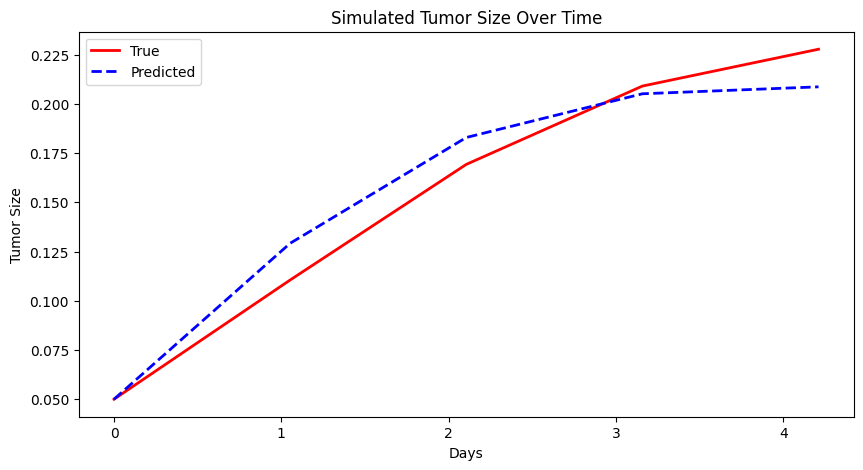

In [9]:
# Plotting the result
plt.figure(figsize=(10, 5))
plt.plot(t[:N_days2], T_true[:N_days2], label="True", linewidth=2, color="red")
plt.plot(t_span_tensor.numpy(), trained_sol[:,0], label="Predicted", linewidth=2, linestyle="--", color="blue")
plt.xlabel("Days")
plt.ylabel("Tumor Size")
plt.title("Simulated Tumor Size Over Time")
plt.legend()
plt.show()

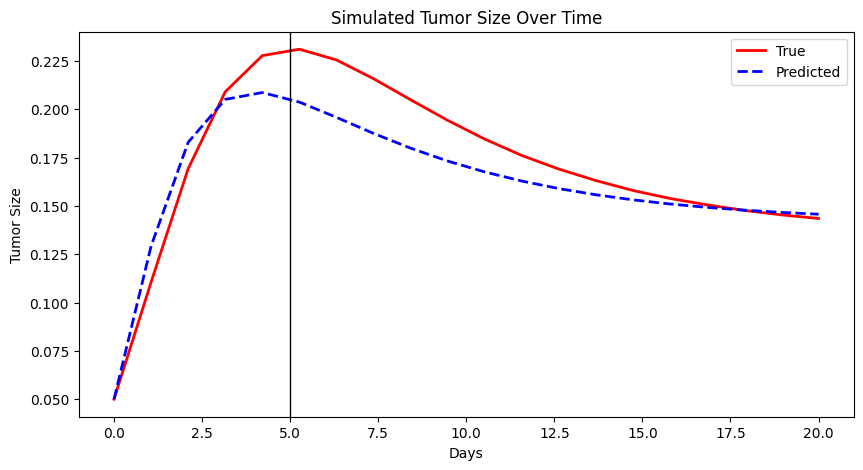

In [10]:
# Forecasting the result
t_span_tensor2 = torch.tensor(t, dtype=torch.float32)
with torch.no_grad():
  trained_sol2 = odeint(trained_model, u0_tensor, t_span_tensor2, method='rk4')

plt.figure(figsize=(10, 5))
plt.plot(t, T_true, label="True", linewidth=2, color="red")
plt.plot(t_span_tensor2.numpy(), trained_sol2[:,0], label="Predicted", linewidth=2, linestyle="--", color="blue")
plt.axvline(x=N_days2, color='black', linestyle='-', linewidth=1)

plt.xlabel("Days")
plt.ylabel("Tumor Size")
plt.title("Simulated Tumor Size Over Time")
plt.legend()
plt.show()